In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import pickle
import os
import pandas as pd
from netCDF4 import Dataset
import h5py

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If available, print the name of the GPU
if cuda_available:
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

def save_dict_to_pickle(data_dict, save_path):
    """
    Saves a dictionary to a specified path using pickle.
    
    Parameters:
    data_dict (dict): The dictionary to save.
    save_path (str): The file path where the dictionary will be saved.
    """
    with open(save_path, 'wb') as file:
        pickle.dump(data_dict, file)


CUDA available: True
Device name: NVIDIA A100-SXM4-40GB
Device count: 1


#### UNet with two decoders (mean head and variance head)

In [17]:
class UNetRes3UQ(nn.Module):
    """
    Builds a UNet of resolution 3 (nomenclature from Williams et al. 2023)
    The resolution is defined as the number of encoder/decoder blocks. The
    number at the end of encoder and decoder blocks denote their depth in 
    the network (thus we have, E1 -> E2 -> E3 -> B -> D3 -> D2 -> D1) where
    B is the bottleneck block
    """

    def __init__(self, in_channels, out_channels, device, spatial_shape=(336, 320), 
                n_channels_factor=1, filter_size=3):

        super(UNetRes3UQ, self).__init__()

        self.encoder1 = self.conv_block(in_channels, int(64 * n_channels_factor), filter_size)
        self.encoder2 = self.conv_block(int(64 * n_channels_factor), int(128 * n_channels_factor), filter_size)
        self.encoder3 = self.conv_block(int(128 * n_channels_factor), int(256 * n_channels_factor), filter_size)

        self.bottleneck = self.conv_block(int(256 * n_channels_factor), int(512 * n_channels_factor), filter_size)
        
        self.decoder3_conv = self.conv(int(512 * n_channels_factor), int(256 * n_channels_factor), filter_size)
        self.decoder3_conv_block = self.conv_block(2 * int(256 * n_channels_factor), int(256 * n_channels_factor), filter_size)

        self.decoder2_conv = self.conv(int(256 * n_channels_factor), int(128 * n_channels_factor), filter_size)
        self.decoder2_conv_block = self.conv_block(2 * int(128 * n_channels_factor), int(128 * n_channels_factor), filter_size)

        self.decoder1_conv_1 = self.conv(int(128 * n_channels_factor), int(64 * n_channels_factor), filter_size)
        self.decoder1_conv_2 = self.conv(int(64 * n_channels_factor), int(64 * n_channels_factor), filter_size)
        
        self.final_conv = nn.Conv2d(int(64 * n_channels_factor), out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Make a land mask tensor that is the same shape as the output tensor
        self.land_mask = self.create_land_mask(spatial_shape).to(device)
    
    def create_land_mask(self, spatial_shape):
        land_mask_npy = ~xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/land_mask.nc").mask.data
        n_y, n_x = land_mask_npy.shape
        pad_y = spatial_shape[0] - n_y
        pad_x = spatial_shape[1] - n_x
        land_mask_npy = np.pad(land_mask_npy, ((pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)
        
        return torch.from_numpy(land_mask_npy).unsqueeze(0).repeat(6, 1, 1)
        
    def conv_block(self, in_channels, out_channels, filter_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )
    
    def conv(self, in_channels, out_channels, filter_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, padding=filter_size//2),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        bottleneck = self.bottleneck(self.pool(enc3))
        
        # decoder for mean head 
        dec3m = self.upsample(bottleneck)
        dec3m = self.decoder3_conv(dec3m)
        dec3m = torch.cat((enc3, dec3m), dim=1)
        dec3m = self.decoder3_conv_block(dec3m)
        
        dec2m = self.upsample(dec3m)
        dec2m = self.decoder2_conv(dec2m)
        dec2m = torch.cat((enc2, dec2m), dim=1)
        dec2m = self.decoder2_conv_block(dec2m)
        
        dec1m = self.upsample(dec2m)
        dec1m = self.decoder1_conv_1(dec1m)
        dec1m = torch.cat((enc1, dec1m), dim=1)
        dec1m = self.decoder1_conv_1(dec1m)
        dec1m = self.decoder1_conv_2(dec1m)
        dec1m = self.decoder1_conv_2(dec1m)

        # decoder for variance head 
        dec3v = self.upsample(bottleneck)
        dec3v = self.decoder3_conv(dec3v)
        dec3v = torch.cat((enc3, dec3v), dim=1)
        dec3v = self.decoder3_conv_block(dec3v)

        dec2v = self.upsample(dec3v)
        dec2v = self.decoder2_conv(dec2v)
        dec2v = torch.cat((enc2, dec2v), dim=1)
        dec2v = self.decoder2_conv_block(dec2v)
        
        dec1v = self.upsample(dec2v)
        dec1v = self.decoder1_conv_1(dec1v)
        dec1v = torch.cat((enc1, dec1v), dim=1)
        dec1v = self.decoder1_conv_1(dec1v)
        dec1v = self.decoder1_conv_2(dec1v)
        dec1v = self.decoder1_conv_2(dec1v)

        # Map the means to (-1, 1)
        mean = torch.tanh(self.final_conv(dec1m))

        # Map the variances to (0, infty)
        softplus = nn.Softplus()
        variance = softplus(self.final_conv(dec1v))

        # Apply the land mask
        mean = mean * self.land_mask
        variance = variance * self.land_mask 

        # Stack the mean and variance tensors along dim=0
        output = torch.stack((mean, variance), dim=0)

        return output


In [3]:

class SeaIceDataset(torch.utils.data.Dataset):
    def __init__(self, data_directory, configuration, split_array, start_prediction_months, \
                split_type='train', target_shape=(336, 320), mode="regression", class_splits=None):
        self.data_directory = data_directory
        self.configuration = configuration
        self.split_array = split_array
        self.start_prediction_months = start_prediction_months
        self.split_type = split_type
        self.target_shape = target_shape
        self.class_splits = class_splits
        self.mode = mode

        # Open the HDF5 files
        self.inputs_file = h5py.File(f"{data_directory}/inputs_{configuration}.h5", 'r')

        if "sicanom" in configuration: 
            targets_configuration = "anom_regression" 
        else: 
            targets_configuration = "regression"

        self.targets_file = h5py.File(f"{data_directory}/targets_{targets_configuration}.h5", 'r')
        
        self.inputs = self.inputs_file[f"inputs_{configuration}"]
        self.targets = self.targets_file['targets_sea_ice_only']

        self.n_samples, self.n_channels, self.n_y, self.n_x = self.inputs.shape
        
        # Get indices for the specified split type
        self.indices = np.where(self.split_array == split_type)[0]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        input_data = self.inputs[actual_idx]
        target_data = self.targets[actual_idx]
        start_prediction_month = self.start_prediction_months[actual_idx]

        # Pad input_data and target_data to the target shape
        pad_y = self.target_shape[0] - self.n_y
        pad_x = self.target_shape[1] - self.n_x
        input_data = np.pad(input_data, ((0, 0), (pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)
        target_data = np.pad(target_data, ((0, 0), (pad_y//2, pad_y//2), (pad_x//2, pad_x//2)), mode='constant', constant_values=0)

        # If we are doing classification, then discretise the target data
        if self.mode == "classification":
            if self.class_splits is None:
                raise ValueError("need to specify a monotonically increasing list class_splits denoting class boundaries")

            # check if class_split is monotonically increasing
            if len(self.class_splits) > 1 and np.any(np.diff(self.class_splits) < 0): 
                raise ValueError("class_splits needs to be monotonically increasing")

            bounds = [] # bounds for classes
            for i,class_split in enumerate(self.class_splits): 
                if i == 0: 
                    bounds.append([0, class_split])
                if i == len(self.class_splits) - 1: 
                    bounds.append([class_split, 1])
                else: 
                    bounds.append([class_split, self.class_splits[i+1]])
            
            target_classes_data = np.zeros_like(target_data) 
            target_classes_data = target_classes_data[np.newaxis,:,:,:]
            target_classes_data = np.repeat(target_classes_data, len(bounds), axis=0)
            for i,bound in enumerate(bounds): 
                if i == len(bounds) - 1: 
                    target_classes_data[i,:,:,:] = np.logical_and(target_data >= bound[0], target_data <= bound[1]).astype(int)
                else:
                    target_classes_data[i,:,:,:] = np.logical_and(target_data >= bound[0], target_data < bound[1]).astype(int)
            
            target_data = target_classes_data 

        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        target_tensor = torch.tensor(target_data, dtype=torch.float32)

        # Get the target months for this sample
        target_months = pd.date_range(start=start_prediction_month, end=start_prediction_month + pd.DateOffset(months=5), freq="MS")
        target_months = target_months.month.to_numpy()
        
        return input_tensor, target_tensor, target_months

    def __del__(self):
        self.inputs_file.close()
        self.targets_file.close()

#### Loss function

In [49]:
class TruncatedNormalBetaNLL(nn.Module):
    """
    A truncated-normal modification of the beta-NLL loss presented in 
    Seitzer et al. (2022) "On the Pitfalls of Heteroscedastic Uncertainty 
    Estimation with Probabilistic Neural Networks"
    """
    
    def __init__(self, beta, a=-1, b=1, epsilon=1e-10): 
        super(TruncatedNormalBetaNLL, self).__init__()
        self.beta = beta
        self.a = a
        self.b = b
        self.epsilon = epsilon
    
    def forward(self, mean, variance, target):
        normal_NLL_loss = 0.5 * ((target - mean) ** 2 / (variance + self.epsilon) + torch.log(variance + self.epsilon))

        if self.beta > 0:
            normal_NLL_loss *= variance.detach() ** self.beta
        
        truncated_normal_scaling = torch.log(torch.erf((self.b - mean)/torch.sqrt(2 * variance + self.epsilon)) \
             - torch.erf((self.a - mean)/torch.sqrt(2 * variance + self.epsilon)) + self.epsilon)

        loss = normal_NLL_loss + truncated_normal_scaling 
        
        return torch.mean(loss)

In [5]:
TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-06-01', freq='MS')

def print_split_stats(split_array):
    ntrain = sum(split_array == 'train')
    nval = sum(split_array == 'val')
    ntest = sum(split_array == 'test')
    
    print(f"train samples: {ntrain} ({round(ntrain / len(split_array), 2)})")
    print(f"val samples: {nval} ({round(nval / len(split_array), 2)})")
    print(f"test samples: {ntest} ({round(ntest / len(split_array), 2)})")

def generate_start_prediction_months(max_month_lead_time=6, max_input_lag_time=12):
    # Construct the date range for the data pairs 
    # Note that this is not continuous due to the missing data in 1987-1988 
    first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=max_month_lead_time+1), freq='MS')
    second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=max_input_lag_time+1), '2024-01', freq='MS')

    return first_range.append(second_range)


def generate_split_array(verbose=1):
    start_prediction_months = generate_start_prediction_months()
    split_array = np.empty(np.shape(start_prediction_months), dtype=object)
    
    for i,month in enumerate(start_prediction_months):
        if month in TRAIN_MONTHS: split_array[i] = "train"
        if month in VAL_MONTHS: split_array[i] = "val"
        if month in TEST_MONTHS: split_array[i] = "test"

    if verbose == 2: print_split_stats(split_array)
    
    return split_array, start_prediction_months
    


In [7]:
split_array, start_prediction_months = generate_split_array()
data_directory = os.path.join(DATA_DIRECTORY, 'sicpred/data_pairs_npy')
configuration = 'all_sicanom'
batch_size = 4

# Create dataset instances for training, validation, and testing
train_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months, \
                              mode='regression', split_type='train', target_shape=(336, 320))
val_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months,\
                            mode='regression', split_type='val', target_shape=(336, 320))
test_dataset = SeaIceDataset(data_directory, configuration, split_array, start_prediction_months, \
                            mode='regression', split_type='test', target_shape=(336, 320))

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetRes3UQ(in_channels=37, out_channels=6, device=device, n_channels_factor=1, filter_size=3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = TruncatedNormalBetaNLL(beta=1)

num_epochs = 5

train_losses = []
val_losses = []
val_predictions = []
val_targets = []
torch.autograd.set_detect_anomaly(True)

for epoch in range(num_epochs): 
    model.train()
    running_loss = 0.0

    for inputs, targets, target_months in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs[0], outputs[1], targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], train loss: {epoch_loss:.4f}", end=', ')

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, target_months in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs[0,:,:,:], outputs[1,:,:,:], targets)
            val_loss += loss.item() * inputs.size(0)
            
            val_targets.append(targets)
            val_predictions.append(outputs) 

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"validation loss: {val_loss:.4f}")


Epoch [1/5], train loss: -0.0976, validation loss: -0.0989
Epoch [2/5], train loss: -0.0981, validation loss: -0.0987
Epoch [3/5], train loss: -0.0982, validation loss: -0.0995
Epoch [4/5], train loss: -0.0982, validation loss: -0.0987
Epoch [5/5], train loss: -0.0982, validation loss: -0.0993


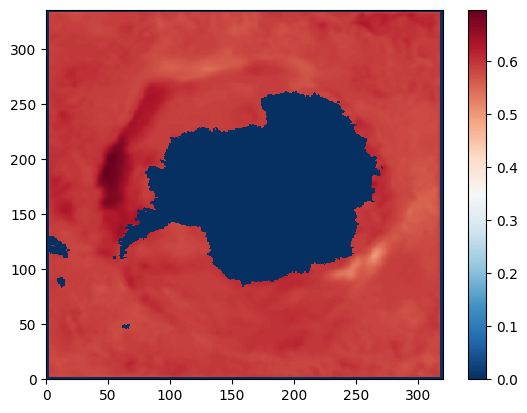

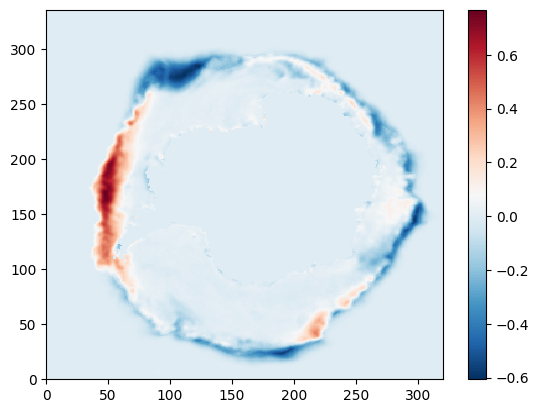

In [62]:
plt.pcolormesh(val_predictions[2][1,0,0,:,:].cpu(), cmap='RdBu_r')
plt.colorbar()
plt.show()

plt.pcolormesh(val_targets[2][0,0,:,:].cpu(), cmap='RdBu_r')
plt.colorbar()
plt.show()

In [ ]:
def train_model(model, device, model_hyperparam_configs, 
                plot_training_curve=True, verbose=1, save_val_predictions=True):

    # read in some metadata
    configuration = model_hyperparam_configs["input_config"]
    batch_size = model_hyperparam_configs["batch_size"]
    early_stopping = model_hyperparam_configs["early_stopping"]
    patience = model_hyperparam_configs["patience"]
    model_name = model_hyperparam_configs["name"]
    num_epochs = model_hyperparam_configs["max_epochs"]

    # generate array labeling which months are train/val/test
    split_array, start_prediction_months = generate_split_array()

    # create dataset instances for training, validation, and testing
    data_pairs_directory = os.path.join(DATA_DIRECTORY, 'sicpred/data_pairs_npy')
    train_dataset = SeaIceDataset(data_pairs_directory, configuration, split_array, start_prediction_months, split_type='train', target_shape=(336, 320))
    val_dataset = SeaIceDataset(data_pairs_directory, configuration, split_array, start_prediction_months, split_type='val', target_shape=(336, 320))
    test_dataset = SeaIceDataset(data_pairs_directory, configuration, split_array, start_prediction_months, split_type='test', target_shape=(336, 320))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

    train_losses = []
    val_losses = []
    val_predictions = []
    best_val_loss = float('inf')
    epoch_at_early_stopping = None
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets, target_months in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets, target_months)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        if verbose >= 1: print(f"Epoch [{epoch+1}/{num_epochs}], train loss: {epoch_loss:.4f}", end=', ')

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, target_months in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets, target_months)
                val_loss += loss.item() * inputs.size(0)        

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        if verbose >= 1: print(f"validation loss: {val_loss:.4f}")

        # Early stopping check
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model weights
                os.makedirs(f"{DATA_DIRECTORY}/sicpred/models", exist_ok=True)
                torch.save(model.state_dict(), f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    if verbose >= 1: print("Early stopping triggered")
                    epoch_at_early_stopping = epoch
                    break
        
    # Plot training curves
    if plot_training_curve:
        plt.figure(figsize=(6, 3))
        plt.plot(np.arange(0.5, len(train_losses) + 0.5, 1), train_losses, label="train")
        plt.plot(np.arange(1, len(val_losses) + 1, 1), val_losses, label="val")
        plt.legend()
        plt.title(model_name)

        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()

        os.makedirs(f"{DATA_DIRECTORY}/figures/training_curves", exist_ok=True)
        plt.savefig(f"{DATA_DIRECTORY}/figures/training_curves/{model_name}_training_curve.png", bbox_inches='tight', dpi=300)
        plt.close()

    # Save the validation predictions for hyperparam tuning 
    if save_val_predictions:
        model.eval()
        with torch.no_grad():
            for inputs, targets, target_months in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_predictions.append(outputs.cpu().numpy())
        os.makedirs(f"{DATA_DIRECTORY}/sicpred/val_predictions", exist_ok=True)
        np.save(f"{DATA_DIRECTORY}/sicpred/val_predictions/{model_name}_val_predictions.npy", np.concatenate(val_predictions, axis=0))

    # Save the trained model
    if verbose >= 1: print("Saving model weights...", end='')

    # record the best val loss and, if early stopping happened, the last epoch
    model_hyperparam_configs["best_val_loss"] = best_val_loss

    if epoch_at_early_stopping is not None: 
        model_hyperparam_configs["final_epoch"] = epoch_at_early_stopping
    else:
        model_hyperparam_configs["final_epoch"] = num_epochs
        
    os.makedirs(f"{DATA_DIRECTORY}/sicpred/val_predictions", exist_ok=True)
    save_dict_to_pickle(model_hyperparam_configs, f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pkl")
    torch.save(model.state_dict(), f"{DATA_DIRECTORY}/sicpred/models/{model_name}.pth")
    if verbose >= 1: print("done! \n\n")

    return train_losses, val_losses

train_model(model, device, model_hyperparam_configs)

In [ ]:
def load_dict_from_pickle(load_path):
    with open(load_path, 'rb') as file:
        data_dict = pickle.load(file)
    return data_dict

model_name = f"UNetRes3_simpleinputs_b1lr1"

predictions = np.load(f"{DATA_DIRECTORY}/sicpred/val_predictions/{model_name}_val_predictions.npy")

with pickle

In [ ]:

nsidc_sic = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc")

model_state_path = os.path.join(f"{DATA_DIRECTORY}/sicpred/models/{model_full_name}.pth")

model.load_state_dict(torch.load(model_state_path, map_location=device))

model.eval()
test_loss = 0.0
inputs_list = []
outputs_list = []
targets_list = []

with torch.no_grad():
    for inputs, targets, target_months in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        inputs_list.append(inputs)
        outputs_list.append(outputs)
        targets_list.append(targets)
        loss = criterion(outputs, targets, target_months)
        print(loss.item() * inputs.size(0))


In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

month_index = 0
lead_time = 0
list_elem = 7

ax1.contourf(nsidc_sic.xgrid, nsidc_sic.ygrid, outputs_list[list_elem][month_index,lead_time,2:334,2:318].cpu(), cmap='nipy_spectral',\
    levels=np.arange(0,1.025,0.025))
cax = ax2.contourf(nsidc_sic.xgrid, nsidc_sic.ygrid, targets_list[list_elem][month_index,lead_time,2:334,2:318].cpu(), cmap='nipy_spectral',\
    levels=np.arange(0,1.025,0.025))

ax1.set_title("Prediction")
ax2.set_title("Truth")

cbar = fig.colorbar(cax, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('Sea ice concentration')

predicted_month = VAL_MONTHS[month_index + lead_time + list_elem*batch_size]

plt.suptitle(rf"Prediction for {predicted_month.month:02}/{predicted_month.year} at {lead_time+1} lead month", fontsize=16)
#plt.savefig(f"../figures/sample_predictions/{model_full_name}_{predicted_month.month:02}_{predicted_month.year}_lead_{lead_time+1}.jpg", dpi=300, bbox_inches='tight')